# Implementando uma MLP básica com Grid Search para escolher melhor os parâmetros

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 100

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para MLP

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorboard.plugins.hparams import api as hp

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### 1.3 Bibliotecas dos sistemas caóticos

In [5]:
import sys 
sys.path.insert(0, '../../../../scripts')

import timeseries as times
import logisticmap as logmap

## 2. Gerando a série temporal do mapa logístico

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original. Utilizaremos  $\tau = 22$, o que faz com que o sistemas esteja em caos.

In [55]:
x_inicial = 0.5
n_inicial = 0
n_iteracoes = 1000
r=3.9
estados = np.array([x_inicial, n_inicial])

In [56]:
mapa = logmap.MapaLogistico(estado_inicial=estados, r=r)

In [57]:
for n in range(0, n_iteracoes):
    mapa.iterar()
    estados = np.vstack((estados, mapa.ler_estado()))

In [58]:
x = estados[:, 0]
n = estados[:, 1]

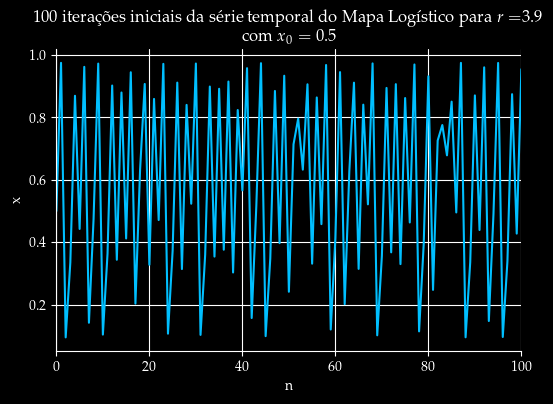

In [59]:
fig, ax = plt.subplots()
ax.plot(n, x, color='DeepSkyBlue')

ax.set_title("100 iterações iniciais da série temporal do Mapa Logístico para $r = $" + str(r) + " \n com $x_{0} =$ " + str(x[0]))
ax.set_ylabel('x')
ax.set_xlabel('n')
ax.set_xlim(0,100)
    
ax.grid(True)
sns.despine()

plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [60]:
K = 4
L = 3
tam_teste = 0.1

In [61]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [62]:
serie_temporal.criar_matrizes()

In [63]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

## 3. Definindo o modelo para a MLP

### 3.1 Definindo parâmetros que não serão definidos pelo Grid Search

In [64]:
param_grid = dict(batch_size=[1, 2, 4, 8, 16, 24, 32, 48, 64, 128], 
                  batch_normalization=['ON', 'OFF'], 
                  activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh', 'logitic'], 
                  init_mode = ['lecun_uniform', 'lecun_normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                  learnig_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

In [65]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()
metrics = tf.keras.metrics.RootMeanSquaredError()

In [66]:
early_stopping_cv = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='root_mean_squared_error')

### 3.2 Definindo as primeiras métricas a serem avaliadas pelo Grid Search

Primeiro, avaliaremos o impacto do *batch size*, da função de ativação e da inicialização dos neurônios, e a taxa de aprendizado. O número de épocas será determinado quando formos treinar a rede, através do *early stopping*.

In [67]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 24, 32, 64, 128], 
                  batch_normalization=['ON', 'OFF'])

### 3.2 Definindo função para criar a MLP

In [68]:
def criar_modelo(batch_normalization='ON', learning_rate=0.001, activation='selu', init_mode='lecun_normal', n_neurons=30):
    
    optimizer_gs = optimizer
    optimizer_gs.learning_rate.assign(learning_rate)
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(K, input_dim=K, name="camada_de_entrada", activation = 'linear'))
    if (batch_normalization == 'ON'):
        model.add(keras.layers.BatchNormalization(name="camada_de_batch_normalization"))
    model.add(keras.layers.Dense(n_neurons, input_dim=K, activation=activation, kernel_initializer=init_mode, name="camada_intermediaria"))
    model.add(keras.layers.Dense(1, activation='linear', name="camada_de_saida"))
    
    model.compile(
        optimizer = optimizer_gs,
        loss = loss,
        metrics = metrics)
    
    model.build()
    return model

In [20]:
model_cv_1 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0)

In [21]:
grid = GridSearchCV(estimator=model, param_grid=param_grid_1, n_jobs=1, cv=4)

In [22]:
grid_result = grid.fit(X_treino, y_treino, callbacks=early_stopping_cv)

In [23]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.030302 using {'batch_normalization': 'OFF', 'batch_size': 2}


### Treino com o melhor modelo

In [77]:
model = criar_modelo(batch_normalization='ON')

In [78]:
model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_de_entrada (Dense)    (None, 4)                 20        
_________________________________________________________________
camada_de_batch_normalizatio (None, 4)                 16        
_________________________________________________________________
camada_intermediaria (Dense) (None, 30)                150       
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 31        
Total params: 217
Trainable params: 209
Non-trainable params: 8
_________________________________________________________________


In [79]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.1)

In [80]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [81]:
batch_size = 32

In [82]:
history = model.fit(X_treino, y_treino, epochs=100,
                            callbacks=early_stopping, validation_data=(X_val, y_val),
                            batch_size=batch_size)
treinamento = pd.DataFrame(history.history)

Epoch 1/100
23/23 [==============================] - 1s 7ms/step - loss: 0.4171 - root_mean_squared_error: 0.5453 - val_loss: 0.1666 - val_root_mean_squared_error: 0.4082
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1176 - root_mean_squared_error: 0.3428 - val_loss: 0.1085 - val_root_mean_squared_error: 0.3294
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1002 - root_mean_squared_error: 0.3166 - val_loss: 0.1131 - val_root_mean_squared_error: 0.3363
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0971 - root_mean_squared_error: 0.3115 - val_loss: 0.1087 - val_root_mean_squared_error: 0.3297
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0908 - root_mean_squared_error: 0.3014 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3219
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0786 - root_mean_squared_error: 0.2803 - val_loss: 0.0910 - val_root_m

## Teste com o melhor modelo

In [83]:
y_pred = model.predict(X_teste)

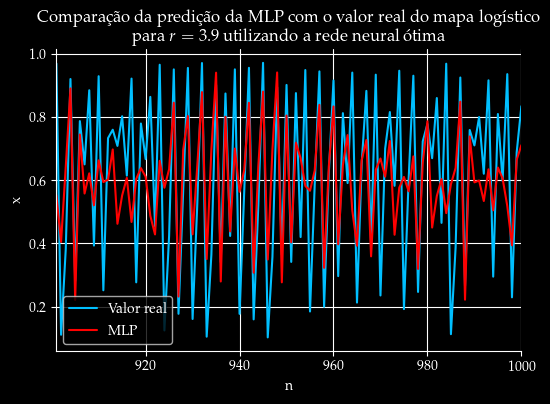

In [84]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='DeepSkyBlue', label='Valor real')
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Red', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do mapa logístico \npara $r = $ " + str(r) + " utilizando a rede neural ótima")
ax.set_ylabel('x')
ax.set_xlabel('n')
ax.set_xlim(901, 1000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()